<a href="https://colab.research.google.com/github/Mdasiftalukdar/Medical-Image-Classification-Employing-DCGAN-and-CNN-Transfer-Learning-Techniques/blob/main/(Updated)_CNN_After_DCGAN_on_X_ray_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import random
import tensorflow as tf

# folder
import os
import glob
import pickle

import cv2
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [ ]:
image_width=128
image_height=128

In [ ]:
%%time
data = []
target = []

for set_ in datasets:
    for cat in categories:
        print(set_ + '/' + cat + '/')
        filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/chest_xray/' + set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((image_height, image_width))) for fname in filelist])


train/NORMAL/
train/PNEUMONIA/
test/NORMAL/
test/PNEUMONIA/
val/NORMAL/
val/PNEUMONIA/
CPU times: user 1min 39s, sys: 2.99 s, total: 1min 42s
Wall time: 4min 8s


In [ ]:
print(np.array(data).shape)
print(np.array(target).shape)

(5856, 128, 128)
(5856,)


In [ ]:
pd.concat([pd.DataFrame(pd.DataFrame({"Target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*7/100).applymap(round).rename(columns={0:"7% data"})
           ], axis=1)

,count,%,7% data
Target,,,
PNEUMONIA,4273,73,299
NORMAL,1583,27,111


In [ ]:
#fake normal image added

filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/selected normal fake images/*.png')
data.extend([np.array(Image.open(fname).convert('L').resize((image_width,image_height))) for fname in filelist])
target.extend(['NORMAL' for _ in filelist])
print(np.array(data).shape)
print(np.array(target).shape)

(5966, 128, 128)
(5966,)


In [ ]:
#fake pneumonia image added

filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/selected pneumonia fake images/*.png')
data.extend([np.array(Image.open(fname).convert('L').resize((image_width, image_height))) for fname in filelist])
target.extend(['PNEUMONIA' for _ in filelist])
print(np.array(data).shape)
print(np.array(target).shape)

(6266, 128, 128)
(6266,)


In [ ]:
pd.concat([pd.DataFrame(pd.DataFrame({"Target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"}),
           ], axis=1)

,count,%
Target,,
PNEUMONIA,4573,73
NORMAL,1693,27


In [ ]:
data_array = np.stack(data, axis=0)

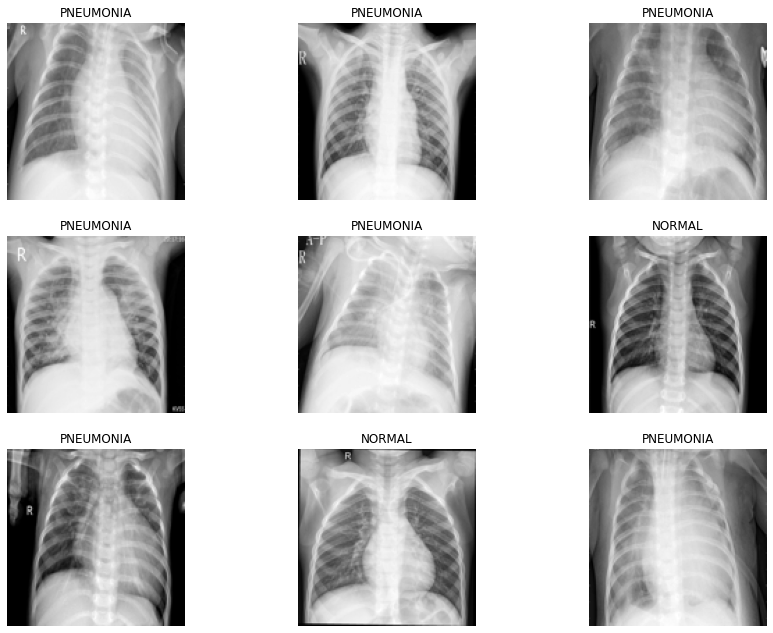

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)

In [ ]:
print(X_train.shape)
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_train.sav'
pickle.dump(X_train, open(filename, 'wb'))

print(X_test.shape)
filename2 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_test.sav'
pickle.dump(X_test, open(filename2, 'wb'))

print(y_train.shape)
filename3 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_train.sav'
pickle.dump(y_train, open(filename3, 'wb'))

print(y_test.shape)

filename4 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_test.sav'
pickle.dump(y_test, open(filename4, 'wb'))

(5012, 128, 128)
(1254, 128, 128)
(5012,)
(1254,)


In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_train.sav'
X_train = pickle.load(open(filename, 'rb'))
print(X_train.shape)

filename2 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_test.sav'
X_test = pickle.load(open(filename2, 'rb'))
print(X_test.shape)

filename3 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_train.sav'
y_train = pickle.load(open(filename3, 'rb'))
print(y_train.shape)

filename4 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_test.sav'
y_test = pickle.load(open(filename4, 'rb'))
print(y_test.shape)

(5012, 128, 128)
(1254, 128, 128)
(5012,)
(1254,)


In [ ]:
pd.DataFrame(y_train).value_counts()/len(y_train)

PNEUMONIA    0.729848
NORMAL       0.270152
dtype: float64

In [ ]:
pd.DataFrame(y_test).value_counts()/len(y_test)

PNEUMONIA    0.729665
NORMAL       0.270335
dtype: float64

In [ ]:
print(X_train.max())
print(X_train.min())

255
0


In [ ]:
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

In [ ]:
print(X_train_norm.max())
print(X_train_norm.min())

1.0
0.0


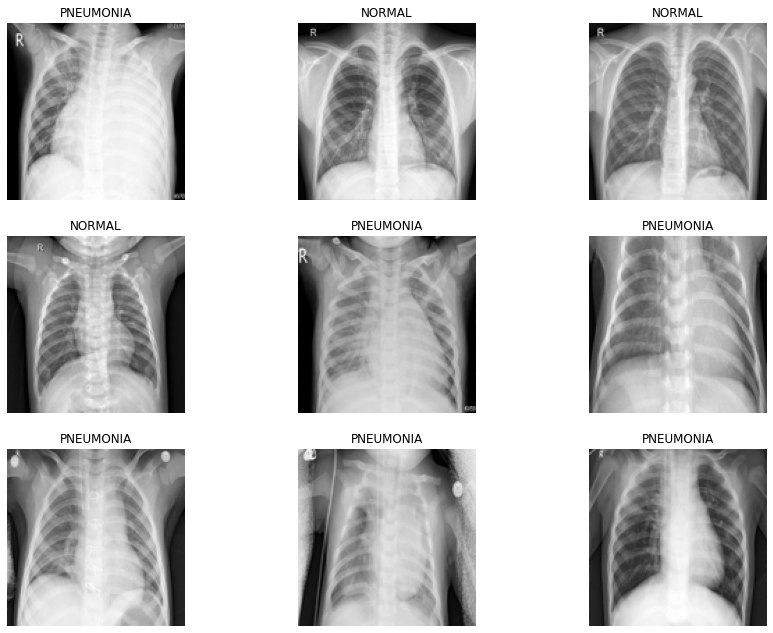

In [ ]:
#images after normalization
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_train_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(y_train[num_image])
        ax.imshow(X_train_norm[num_image]);

In [ ]:
display(np.array(y_train).shape)
display(np.unique(y_train))
display(np.array(y_test).shape)
display(np.unique(y_test))
print(y_test)

(5012,)

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

(1254,)

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

['PNEUMONIA' 'PNEUMONIA' 'NORMAL' ... 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA']


In [ ]:
encoder = LabelEncoder().fit(y_train) #normal = 0, pneumonia = 1
y_train_cat = encoder.transform(y_train)
y_test_cat = encoder.transform(y_test)

In [ ]:
print(X_train_norm.shape)
print(X_test_norm.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)
display(np.unique(y_test_cat))
print(y_test_cat)

(5012, 128, 128)
(1254, 128, 128)
(5012,)
(1254,)


array([0, 1])

[1 1 0 ... 1 1 1]


In [ ]:
#for coustom cnn with 1 dimension
X_train_cnn = X_train_norm.reshape(-1, image_width, image_height, 1)
X_test_cnn = X_test_norm.reshape(-1, image_width, image_height, 1)
print(X_train_cnn.shape)
print(X_test_cnn.shape)

(5012, 128, 128, 1)
(1254, 128, 128, 1)


In [ ]:
#for transfer learning models
X_train_tl = np.repeat(X_train_norm[..., np.newaxis], 3, -1)
X_test_tl = np.repeat(X_test_norm[..., np.newaxis], 3, -1)
print(X_train_tl.shape)
print(X_test_tl.shape)

(5012, 128, 128, 3)
(1254, 128, 128, 3)


In [ ]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(5012,)
(1254,)


# **Custom CNN**

In [ ]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(image_height, image_width, 1), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model

In [ ]:
%%time
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

cnn_gan = model.fit(X_train_cnn, y_train_cat,
                    batch_size=8,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/20
439/439 [==============================] - 11s 23ms/step - loss: 0.4481 - accuracy: 0.7948 - val_loss: 0.2913 - val_accuracy: 0.8903
Epoch 2/20
439/439 [==============================] - 9s 21ms/step - loss: 0.2037 - accuracy: 0.9216 - val_loss: 0.1596 - val_accuracy: 0.9408
Epoch 3/20
439/439 [==============================] - 9s 21ms/step - loss: 0.1478 - accuracy: 0.9461 - val_loss: 0.1505 - val_accuracy: 0.9422
Epoch 4/20
439/439 [==============================] - 9s 22ms/step - loss: 0.1266 - accuracy: 0.9484 - val_loss: 0.1329 - val_accuracy: 0.9555
Epoch 5/20
439/439 [==============================] - 9s 21ms/step - loss: 0.1032 - accuracy: 0.9627 - val_loss: 0.1334 - val_accuracy: 0.9614
Epoch 6/20
439/439 [==============================] - 9s 21ms/step - loss: 0.0978 - accuracy: 0.9635 - val_loss: 0.1162 - val_accuracy: 0.9574
Epoch 7/20
439/439 [==============================] - 9s 21ms/step - loss: 0.0985 - accuracy: 0.9635 - val_loss: 0.1423 - val_accuracy: 0.951

In [ ]:
model.evaluate(X_test_cnn, y_test_cat, verbose=1)

40/40 [==============================] - 1s 18ms/step - loss: 0.1522 - accuracy: 0.9553


[0.15215733647346497, 0.9553428888320923]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/custom_CNN_with_fake_data.sav'
#pickle.dump(model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/custom_CNN_fit_with_fake_data.sav'
#pickle.dump(cnn_gan, open(filenamefit, 'wb'))

filename1 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_cnn_with_fake_data.sav'
#pickle.dump(X_test_cnn, open(filename1, 'wb'))

filename2 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/y_cnn_with_fake_data.sav'
#pickle.dump(y_test_cat, open(filename2, 'wb'))

In [ ]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
x_cnn = pickle.load(open(filename1, 'rb'))
y = pickle.load(open(filename2, 'rb'))
loaded_model.evaluate(x_cnn, y, verbose=1)

40/40 [==============================] - 1s 17ms/step - loss: 0.1865 - accuracy: 0.9609


[0.18646705150604248, 0.9609250426292419]

In [ ]:
loaded_model_fit = pickle.load(open(filenamefit, 'rb'))

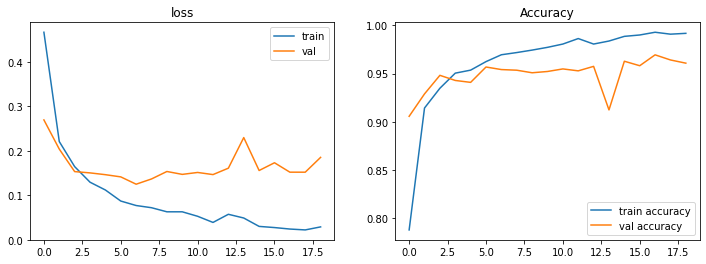

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(loaded_model_fit, title='', axs=None, exp_name="");

In [ ]:
y_pred = loaded_model.predict(x_cnn)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       339
           1       0.98      0.97      0.97       915

    accuracy                           0.96      1254
   macro avg       0.95      0.95      0.95      1254
weighted avg       0.96      0.96      0.96      1254

[[318  21]
 [ 28 887]]


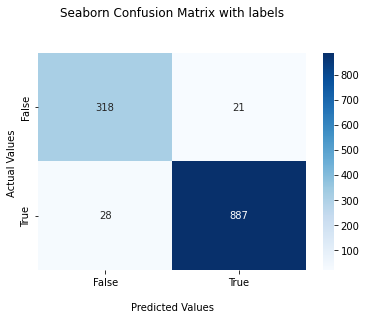

In [ ]:
def heatmap(x):
  ax = sns.heatmap(x, annot=True, fmt='', cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()
heatmap(cf)

## **Result visualizing**

In [ ]:
predictions = model.predict(x_cnn)

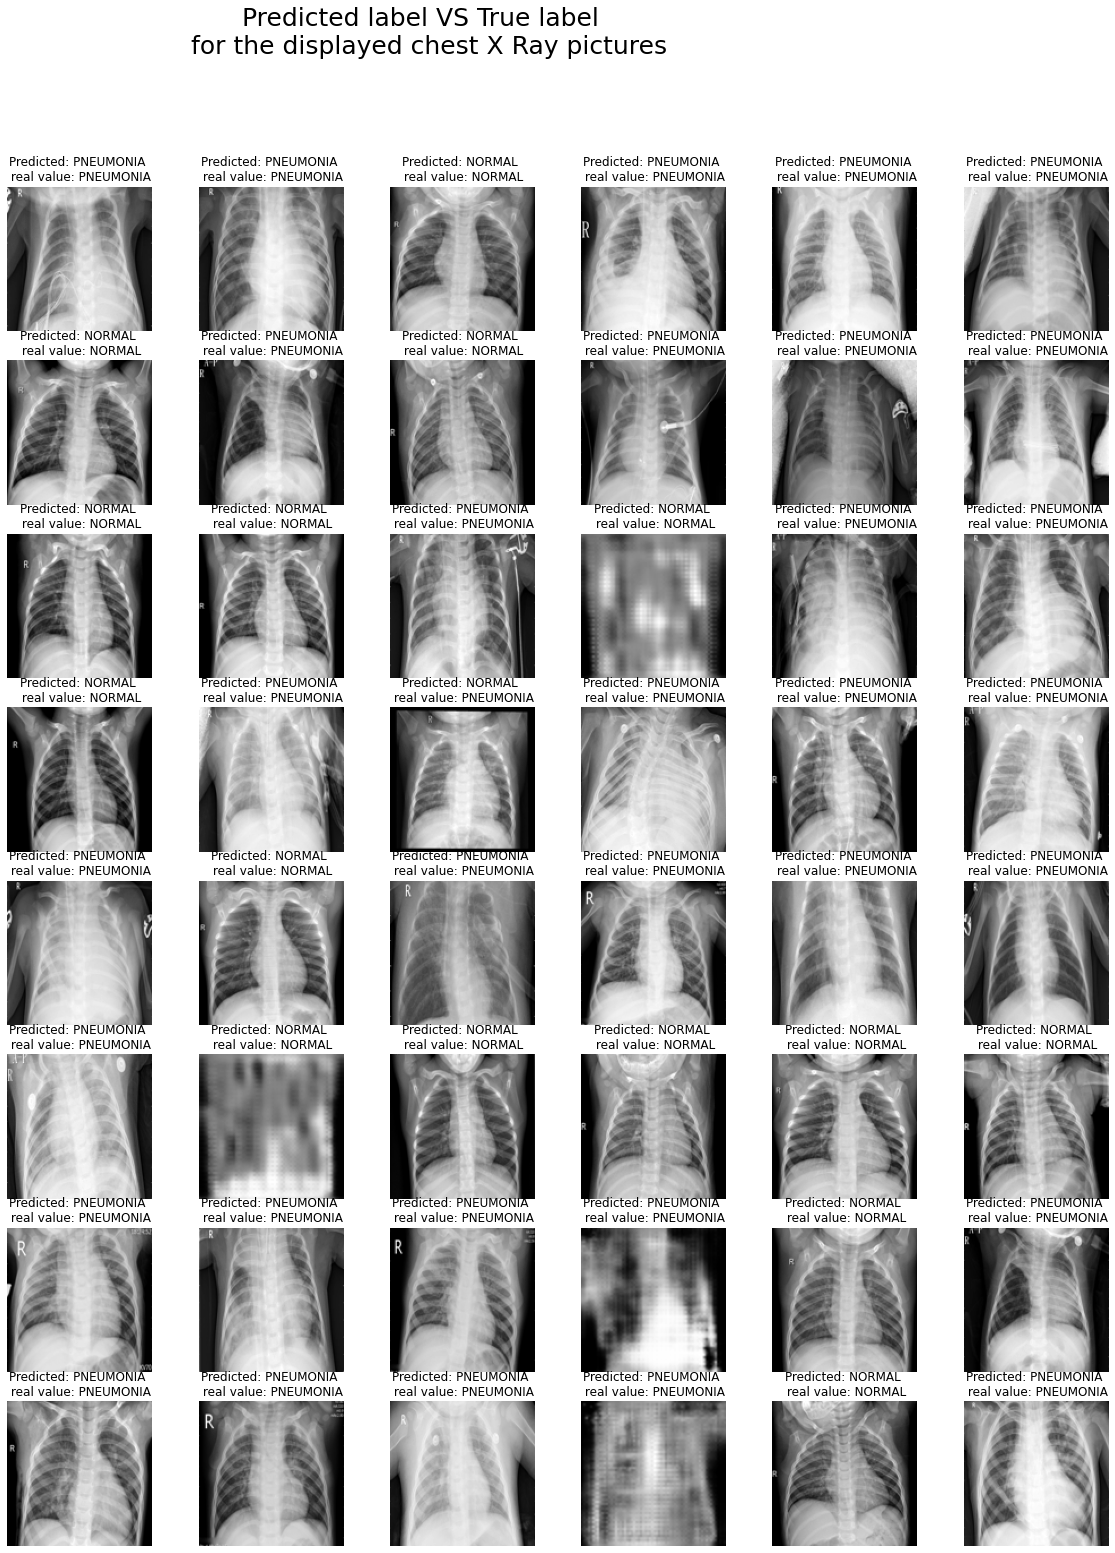

In [ ]:
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(8, 6)
#
for row in range(0, 8):
    for col in range(0, 6):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[int(np.round(predictions)[num_image][0])] + " \n real value: " + categories[y_test_cat[num_image]])
        ax.imshow(X_test [num_image]);
fig.suptitle("Predicted label VS True label \n for the displayed chest X Ray pictures", fontsize=25, x=0.42);
#plt.tight_layout;

# **Transfer Learnings**

In [ ]:
print(X_train_tl.shape)
print(X_test_tl.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(5012, 128, 128, 3)
(1254, 128, 128, 3)
(5012,)
(1254,)


## **1. inception v3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_inception = InceptionV3(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
#freezing layers
for layer in base_inception.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_inception.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

inception_model = tf.keras.models.Model(base_inception.input, x)

inception_model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
inception = inception_model.fit(X_train_tl, y_train_cat ,validation_split=0.3, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 12s 121ms/step - loss: 0.0232 - acc: 0.9966 - val_loss: 0.8385 - val_acc: 0.9515
Epoch 2/20
100/100 [==============================] - 14s 138ms/step - loss: 0.0085 - acc: 0.9969 - val_loss: 0.8178 - val_acc: 0.9428
Epoch 3/20
100/100 [==============================] - 12s 117ms/step - loss: 0.0088 - acc: 0.9986 - val_loss: 0.8549 - val_acc: 0.9488
Epoch 4/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0170 - acc: 0.9964 - val_loss: 0.8681 - val_acc: 0.9508
Epoch 5/20
100/100 [==============================] - 14s 139ms/step - loss: 0.0173 - acc: 0.9975 - val_loss: 0.9508 - val_acc: 0.9455
Epoch 6/20
100/100 [==============================] - 14s 138ms/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.8084 - val_acc: 0.9475
Epoch 7/20
100/100 [==============================] - 12s 117ms/step - loss: 0.0082 - acc: 0.9986 - val_loss: 0.9194 - val_acc: 0.9488
Epoch 8/20
100/100 [==============================] - 1

In [ ]:
inception_model.evaluate(X_test_tl, y_test_cat)

40/40 [==============================] - 3s 76ms/step - loss: 0.7313 - acc: 0.9553


[0.7313011884689331, 0.9553428888320923]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/inception_with_fake_data.sav'
pickle.dump(inception_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/inception_fit_with_fake_data.sav'
pickle.dump(inception, open(filenamefit, 'wb'))

filename1 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_tf_with_fake_data.sav'
pickle.dump(X_test_tl, open(filename1, 'wb'))



INFO:tensorflow:Assets written to: ram://6acece10-6a4d-406b-b49e-739b4f273f47/assets
INFO:tensorflow:Assets written to: ram://5b0b9f49-fff6-466c-bac0-384e7bb048f5/assets


In [ ]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
x_tf = pickle.load(open(filename1, 'rb'))

loaded_model.evaluate(x_tf, y, verbose=1)

40/40 [==============================] - 5s 75ms/step - loss: 0.5450 - acc: 0.9514


[0.5450073480606079, 0.9513556361198425]

In [ ]:
y_pred = inception_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       339
           1       0.97      0.97      0.97       915

    accuracy                           0.96      1254
   macro avg       0.95      0.94      0.94      1254
weighted avg       0.96      0.96      0.96      1254

[[307  32]
 [ 24 891]]


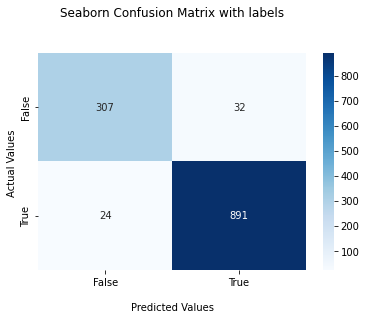

In [ ]:
heatmap(cf)

## **2. Resnet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
base_resnet = ResNet50(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_resnet.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_resnet.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

resnet_model = tf.keras.models.Model(base_resnet.input, x)

resnet_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
resnet = resnet_model.fit(X_train_tl, y_train_cat ,validation_split=0.3, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 23s 179ms/step - loss: 0.5830 - acc: 0.7327 - val_loss: 0.5925 - val_acc: 0.7094
Epoch 2/20
100/100 [==============================] - 16s 159ms/step - loss: 0.5643 - acc: 0.7433 - val_loss: 0.5932 - val_acc: 0.7094
Epoch 3/20
100/100 [==============================] - 16s 159ms/step - loss: 0.5699 - acc: 0.7341 - val_loss: 0.5842 - val_acc: 0.7094
Epoch 4/20
100/100 [==============================] - 14s 145ms/step - loss: 0.5599 - acc: 0.7422 - val_loss: 0.5844 - val_acc: 0.7094
Epoch 5/20
100/100 [==============================] - 14s 145ms/step - loss: 0.5633 - acc: 0.7372 - val_loss: 0.5806 - val_acc: 0.7094
Epoch 6/20
100/100 [==============================] - 14s 145ms/step - loss: 0.5534 - acc: 0.7397 - val_loss: 0.5768 - val_acc: 0.7094
Epoch 7/20
100/100 [==============================] - 15s 146ms/step - loss: 0.5579 - acc: 0.7366 - val_loss: 0.5742 - val_acc: 0.7094
Epoch 8/20
100/100 [==============================] - 1

In [ ]:
resnet_model.evaluate(X_test_tl, y_test_cat)

40/40 [==============================] - 5s 101ms/step - loss: 0.5249 - acc: 0.7297


[0.5249199867248535, 0.7296651005744934]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/resnet_fake.sav'
pickle.dump(resnet_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/resnet_fit_fake.sav'
pickle.dump(resnet, open(filenamefit, 'wb'))



INFO:tensorflow:Assets written to: ram://50b89b49-70a2-4123-ab23-982305942d9f/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ram://68dec408-9323-437b-bf48-67a40c1bc1c2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

40/40 [==============================] - 5s 88ms/step - loss: 0.5260 - acc: 0.7297


[0.5260228514671326, 0.7296651005744934]

In [ ]:
y_pred = resnet_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       339
           1       0.73      1.00      0.84       915

    accuracy                           0.73      1254
   macro avg       0.36      0.50      0.42      1254
weighted avg       0.53      0.73      0.62      1254

[[  0 339]
 [  0 915]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


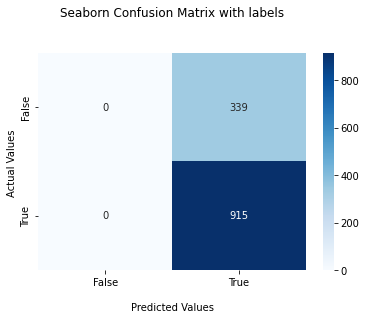

In [ ]:
heatmap(cf)

# **3. efficient net B0**


In [ ]:
base_efficient = tf.keras.applications.EfficientNetB0(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
#freezing the layers
for layer in base_efficient.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_efficient.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

efficient_model = tf.keras.models.Model(base_efficient.input, x)

efficient_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
efficient = efficient_model.fit(X_train_tl, y_train_cat ,validation_split=0.3, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 22s 144ms/step - loss: 0.6466 - acc: 0.7067 - val_loss: 0.6202 - val_acc: 0.7094
Epoch 2/20
100/100 [==============================] - 9s 92ms/step - loss: 0.5884 - acc: 0.7369 - val_loss: 0.6067 - val_acc: 0.7094
Epoch 3/20
100/100 [==============================] - 9s 94ms/step - loss: 0.5864 - acc: 0.7380 - val_loss: 0.6327 - val_acc: 0.7094
Epoch 4/20
100/100 [==============================] - 9s 94ms/step - loss: 0.5858 - acc: 0.7366 - val_loss: 0.6027 - val_acc: 0.7094
Epoch 5/20
100/100 [==============================] - 9s 90ms/step - loss: 0.5802 - acc: 0.7425 - val_loss: 0.6539 - val_acc: 0.7094
Epoch 6/20
100/100 [==============================] - 9s 94ms/step - loss: 0.5880 - acc: 0.7355 - val_loss: 0.6045 - val_acc: 0.7094
Epoch 7/20
100/100 [==============================] - 9s 90ms/step - loss: 0.5788 - acc: 0.7394 - val_loss: 0.6068 - val_acc: 0.7094
Epoch 8/20
100/100 [==============================] - 9s 90ms/step 

In [ ]:
efficient_model.evaluate(X_test_tl, y_test_cat)

40/40 [==============================] - 4s 66ms/step - loss: 0.5845 - acc: 0.7297


[0.5845380425453186, 0.7296651005744934]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/efficient.sav'
pickle.dump(efficient_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/efficient_fit.sav'
pickle.dump(efficient, open(filenamefit, 'wb'))


INFO:tensorflow:Assets written to: ram://dc99d00c-2088-44c5-ae47-10966fbf68ab/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ram://c70e1a84-45d7-4684-bfeb-ef0da6d1eac9/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

40/40 [==============================] - 4s 58ms/step - loss: 0.5836 - acc: 0.7297


[0.5835651755332947, 0.7296651005744934]

In [ ]:
y_pred = efficient_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
pd.DataFrame(y_pred)[0].unique()

array([1.], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       339
           1       0.73      1.00      0.84       915

    accuracy                           0.73      1254
   macro avg       0.36      0.50      0.42      1254
weighted avg       0.53      0.73      0.62      1254

[[  0 339]
 [  0 915]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


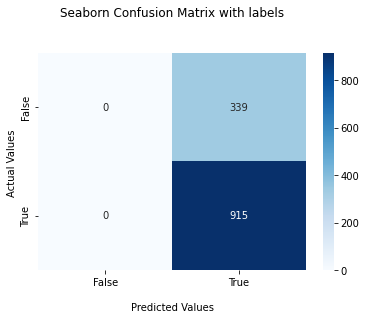

In [ ]:
heatmap(cf)

#**4. VGG 16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_vgg16.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_vgg16.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

vgg16_model = tf.keras.models.Model(base_vgg16.input, x)

vgg16_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
vgg16 = vgg16_model.fit(X_train_tl, y_train_cat ,validation_split=0.3, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 18s 177ms/step - loss: 1.5468e-04 - acc: 1.0000 - val_loss: 0.1699 - val_acc: 0.9701
Epoch 2/20
100/100 [==============================] - 16s 159ms/step - loss: 1.3941e-04 - acc: 1.0000 - val_loss: 0.1738 - val_acc: 0.9701
Epoch 3/20
100/100 [==============================] - 17s 171ms/step - loss: 1.1288e-04 - acc: 1.0000 - val_loss: 0.1751 - val_acc: 0.9688
Epoch 4/20
100/100 [==============================] - 16s 158ms/step - loss: 1.0270e-04 - acc: 1.0000 - val_loss: 0.1771 - val_acc: 0.9688
Epoch 5/20
100/100 [==============================] - 17s 171ms/step - loss: 1.0539e-04 - acc: 1.0000 - val_loss: 0.1766 - val_acc: 0.9701
Epoch 6/20
100/100 [==============================] - 16s 158ms/step - loss: 8.6719e-05 - acc: 1.0000 - val_loss: 0.1805 - val_acc: 0.9694
Epoch 7/20
100/100 [==============================] - 16s 158ms/step - loss: 8.7786e-05 - acc: 1.0000 - val_loss: 0.1793 - val_acc: 0.9688
Epoch 8/20
100/100 [=======

In [ ]:
vgg16_model.evaluate(X_test_tl, y_test_cat)

40/40 [==============================] - 3s 86ms/step - loss: 0.1838 - acc: 0.9689


[0.18376097083091736, 0.9688995480537415]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/vgg16_with_fake_data.sav'
pickle.dump(vgg16_model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://c110174f-fe97-4fa9-94b4-efaa282aa7e2/assets


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

40/40 [==============================] - 4s 87ms/step - loss: 0.1547 - acc: 0.9841


[0.15474383533000946, 0.9840510487556458]

In [ ]:
y_pred = vgg16_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       339
           1       0.98      0.98      0.98       915

    accuracy                           0.97      1254
   macro avg       0.96      0.96      0.96      1254
weighted avg       0.97      0.97      0.97      1254

[[318  21]
 [ 18 897]]


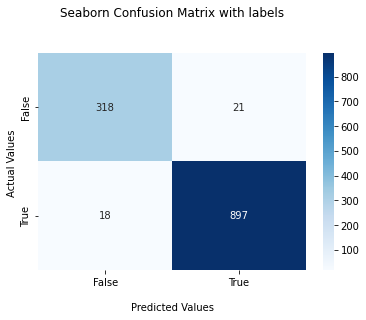

In [ ]:
heatmap(cf)

#**5. densenet 201**

In [ ]:
base_densenet = tf.keras.applications.densenet.DenseNet201(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_densenet.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_densenet.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

densenet_model = tf.keras.models.Model(base_densenet.input, x)

densenet_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
densenet = densenet_model.fit(X_train_tl, y_train_cat ,validation_split=0.3, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 53s 340ms/step - loss: 0.3171 - acc: 0.8939 - val_loss: 0.1239 - val_acc: 0.9535
Epoch 2/20
100/100 [==============================] - 24s 242ms/step - loss: 0.1014 - acc: 0.9615 - val_loss: 0.1135 - val_acc: 0.9574
Epoch 3/20
100/100 [==============================] - 28s 278ms/step - loss: 0.0748 - acc: 0.9746 - val_loss: 0.1301 - val_acc: 0.9508
Epoch 4/20
100/100 [==============================] - 24s 242ms/step - loss: 0.0681 - acc: 0.9751 - val_loss: 0.1016 - val_acc: 0.9648
Epoch 5/20
100/100 [==============================] - 28s 278ms/step - loss: 0.0493 - acc: 0.9816 - val_loss: 0.1020 - val_acc: 0.9601
Epoch 6/20
100/100 [==============================] - 28s 279ms/step - loss: 0.0422 - acc: 0.9855 - val_loss: 0.1114 - val_acc: 0.9601
Epoch 7/20
100/100 [==============================] - 24s 243ms/step - loss: 0.0298 - acc: 0.9891 - val_loss: 0.1126 - val_acc: 0.9648
Epoch 8/20
100/100 [==============================] - 2

In [ ]:
densenet_model.evaluate(X_test_tl, y_test_cat)

40/40 [==============================] - 12s 198ms/step - loss: 0.1563 - acc: 0.9681


[0.15632213652133942, 0.9681020975112915]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/densenet_with_fake_data.sav'
pickle.dump(densenet_model, open(filename, 'wb'))

filenamefit = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/densenet_fit_with_fake_data.sav'
pickle.dump(densenet, open(filenamefit, 'wb'))

INFO:tensorflow:Assets written to: ram://b8861c3b-ec86-43f1-8699-fec71ea2de82/assets
INFO:tensorflow:Assets written to: ram://21cccf3d-e265-4b02-9bd2-66a054afe0c5/assets


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.evaluate(x_tf, y, verbose=1)

KeyboardInterrupt: ignored

In [ ]:
y_pred = densenet_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       339
           1       0.97      0.98      0.98       915

    accuracy                           0.97      1254
   macro avg       0.96      0.96      0.96      1254
weighted avg       0.97      0.97      0.97      1254

[[315  24]
 [ 16 899]]


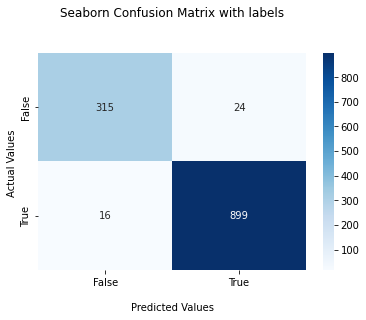

In [ ]:
heatmap(cf)

# **6. Xception**

In [ ]:
base_xception = tf.keras.applications.xception.Xception(input_shape = (image_height, image_width, 3), include_top = False, weights = 'imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
#freezing the layers
for layer in base_xception.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_xception.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

xception_model = tf.keras.models.Model(base_xception.input, x)

xception_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
%%time
xception = xception_model.fit(X_train_tl, y_train_cat ,validation_split=0.3, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 30s 256ms/step - loss: 0.2676 - acc: 0.8944 - val_loss: 0.2179 - val_acc: 0.9116
Epoch 2/20
100/100 [==============================] - 19s 186ms/step - loss: 0.1542 - acc: 0.9397 - val_loss: 0.1554 - val_acc: 0.9402
Epoch 3/20
100/100 [==============================] - 18s 183ms/step - loss: 0.1476 - acc: 0.9441 - val_loss: 0.1762 - val_acc: 0.9355
Epoch 4/20
100/100 [==============================] - 19s 186ms/step - loss: 0.1116 - acc: 0.9589 - val_loss: 0.1592 - val_acc: 0.9435
Epoch 5/20
100/100 [==============================] - 19s 186ms/step - loss: 0.0954 - acc: 0.9656 - val_loss: 0.1772 - val_acc: 0.9388
Epoch 6/20
100/100 [==============================] - 18s 183ms/step - loss: 0.0866 - acc: 0.9690 - val_loss: 0.1605 - val_acc: 0.9448
Epoch 7/20
100/100 [==============================] - 18s 183ms/step - loss: 0.0728 - acc: 0.9743 - val_loss: 0.1536 - val_acc: 0.9468
Epoch 8/20
100/100 [==============================] - 1

In [ ]:
xception_model.evaluate(X_test_tl, y_test_cat)

40/40 [==============================] - 6s 122ms/step - loss: 0.2593 - acc: 0.9426


[0.2592872679233551, 0.9425837397575378]

In [ ]:
import pickle
# saving the model 
filename = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/xception_with_fake_data.sav'
pickle.dump(xception_model, open(filename, 'wb'))

filename1 = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/save1/X_xception_fit_with_fake_data.sav'
pickle.dump(xception, open(filename1, 'wb'))



INFO:tensorflow:Assets written to: ram://6f19741c-41de-43ff-9443-122ffccd31d5/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: ram://ce39c713-0e28-4eff-bf08-51dd6d577a99/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#loading model
loaded_model = pickle.load(open(filename, 'rb'))


loaded_model.evaluate(X_test_tl, y_test_cat, verbose=1)

40/40 [==============================] - 5s 110ms/step - loss: 0.2667 - acc: 0.9474


[0.26672109961509705, 0.9473684430122375]

In [ ]:
y_pred = xception_model.predict(X_test_tl)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cat, y_pred))
cf = confusion_matrix(y_test_cat, y_pred)
print(cf)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       339
           1       0.98      0.95      0.96       915

    accuracy                           0.94      1254
   macro avg       0.92      0.94      0.93      1254
weighted avg       0.95      0.94      0.94      1254

[[317  22]
 [ 50 865]]


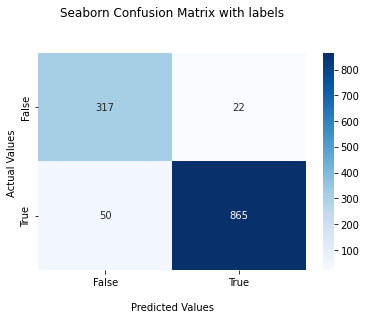

In [ ]:
heatmap(cf)